# Pruning puf2011 for regression

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import json as js
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Loads variable meta-data from https://github.com/andersonfrailey/taxdata/blob/f17d6053d09536e7c2e198a6640c2bd0843deeb0/tests/records_metadata.json
true = 'true'
meta0 = open('records_metadata.json')
meta = js.load(meta0)
pufcps = []

#Creates list containing those variables available in both cps and puf by including those variables who have two elements in their 'availability' section in the JSON metadata
for i in meta:
    if len(meta[i]['availability'].split(',')) == 2:
        pufcps.append(i)

#Many variables shared between puf/cps are not in puf2011 and cannot be used in puf2011 -> cps imputation, these unshared variables are listed so they may be removed
notpuf2011 = ['agi_bin','age_head','age_spouse','e00200p','e00200s', 'e00900p','e00900s','e02100p','e02100s','elderly_dependent','filer','fips', 'nu05','nu13','nu18','n1820','n21']

#Creates list of variables in both puf2011 and cps
puf2011cps = [x for x in pufcps if x not in notpuf2011]

#Creates dictionary containing meta-data on puf2011cps variables, pulled from JSON meta-data
meta_puf2011cps = {}
for i in meta:
    if i in puf2011cps:
        meta_puf2011cps[i] = meta[i]['desc'] 

#Capitalizes variables to align with puf2011's formatting
puf2011cps = [x.upper() for x in puf2011cps]

#Adds to puf2011 those variables which we are trying to impute to cps. By definition they are not in cps, but, we intend to keep them in puf2011 so we can model them.
# Also adds AGIR1 for validation purposes
puf2011cps.extend(['E02000','E26270','P22250','P23250', 'AGIR1'])

meta_puf2011cps

{'DSI': '1 if claimed as dependent on another return; otherwise 0',
 'EIC': 'number of EIC qualifying children (range: 0 to 3)',
 'FLPDYR': 'Calendar year for which taxes are calculated',
 'MARS': 'Filing (marital) status: line number of the checked box [1=single, 2=joint, 3=separate, 4=household-head, 5=widow(er)]',
 'RECID': 'Unique numeric identifier for filing unit; appears as RECID variable in tc CLI minimal output',
 'XTOT': 'Total number of exemptions for filing unit',
 'e00200': 'Wages, salaries, and tips for filing unit',
 'e00300': 'Taxable interest income',
 'e00400': 'Tax-exempt interest income',
 'e00600': 'Ordinary dividends included in AGI',
 'e00650': 'Qualified dividends included in ordinary dividends',
 'e00800': 'Alimony received',
 'e00900': 'Sch C business net profit/loss for filing unit',
 'e01100': 'Capital gain distributions not reported on Sch D',
 'e01400': 'Taxable IRA distributions',
 'e01500': 'Total pensions and annuities',
 'e01700': 'Taxable pensions and

In [3]:
puf2011 = pd.read_csv('puf2011.csv')

#Drops colums that are not in puf2011cps
for i in puf2011.columns:
    if i not in puf2011cps:
        puf2011.drop(i, axis=1, inplace=True)

#Adds constant, removes aggregate rows
puf2011['constant'] = np.ones(len(puf2011))
puf2011 = puf2011[(puf2011.RECID != 999996) & 
                  (puf2011.RECID != 999997) & 
                  (puf2011.RECID != 999998) &
                  (puf2011.RECID != 999999)]

In [4]:
#Create dummy variable columns from MARS
puf2011 = pd.concat([puf2011, pd.get_dummies(puf2011['MARS'])], axis=1)

In [5]:
#Rename dummy columns
puf2011.rename(columns = {1:'MARS1', 2:'MARS2', 3:'MARS3', 4:'MARS4'}, inplace=True)

In [6]:
#Creates sub-dataframes where variables of interest are non-zero
pufE02 = puf2011[(puf2011['E02000']!=0)]
pufE26 = puf2011[(puf2011['E26270']!=0)]
pufP22 = puf2011[(puf2011['P22250']!=0)]
pufP23 = puf2011[(puf2011['P23250']!=0)]

# Models & parameter extraction

In [7]:
E02000_model = sm.OLS(pufE02['E02000'], 
                      pufE02[['E00200','E00300','E18400','E18500','E00600',
                              'E03240','E03300','E20400','E19800','E20100',
                              'MARS1', 'MARS2', 'MARS3', 'MARS4','constant']].dropna()).fit()
#E02000_model.summary()

In [8]:
E26270_model = sm.OLS(pufE26['E26270'], 
                      pufE26[['E00200','E00300','E18400','E18500','E00600',
                              'E03240','E03300','E20400','E19800','E20100',
                              'MARS1', 'MARS2', 'MARS3', 'MARS4','constant']].dropna()).fit()
#E26270_model.summary()

In [9]:
P22250_model = sm.OLS(pufP22['P22250'], 
                      pufP22[['E00200','E00300','E18400','E18500','E00600',
                              'E03240','E03300','E20400','E19800','E20100',
                              'MARS1', 'MARS2', 'MARS3', 'MARS4','constant']].dropna()).fit()
#P22250_model.summary()

In [10]:
P23250_model = sm.OLS(pufP23['P23250'], 
                      pufP23[['E00200','E00300','E18400','E18500','E00600',
                              'E03240','E03300','E20400','E19800','E20100',
                              'MARS1', 'MARS2', 'MARS3', 'MARS4','constant']].dropna()).fit()
#P23250_model.summary()

In [11]:
#Extract all parameters
betas = pd.DataFrame({'E02000_model':E02000_model.params,
                      'E26270_model':E26270_model.params,
                      'P22250_model':P22250_model.params,
                      'P23250_model':P23250_model.params}).fillna(0.)
betas.to_csv('Data_betas.csv')

#Revert variable names to lowercase to impute to cps data
betas.index = betas.index.str.lower()
betas.columns = betas.columns.str.lower()
betas

,e02000_model,e26270_model,p22250_model,p23250_model
e00200,-0.151295,-0.143629,0.011823,-0.122266
e00300,-0.668974,-0.675833,0.103493,0.426146
e18400,1.786382,1.729942,-0.008635,1.442818
e18500,6.382758,5.530040,-0.381311,5.748795
e00600,-0.195745,-0.200233,0.003242,0.210423
e03240,9.105109,8.271007,-0.078776,-0.923082
e03300,5.759980,6.186928,0.246197,-2.973196
e20400,-1.072585,-0.974689,0.148788,2.995975
e19800,0.978106,0.869899,0.029935,0.364107
e20100,0.396913,0.360117,-0.048357,0.325359


# Imputation

In [12]:
#Create MARS dummy columns in cps, renames them to match betas, add mars3 column of 0's (it turns out that in cps,  MARS != 3)
cps = pd.read_csv('cps.csv')
cps = pd.concat([cps, pd.get_dummies(cps['MARS'])], axis = 1)
cps.rename(columns = {1: 'mars1', 2: 'mars2', 4: 'mars4'}, inplace=True)
cps['mars3'] = 0


In [32]:
#Creates list of dependent variables, fetches cps data, adds constant column for imputation
dependents = ['e02000','e26270','p22250','p23250']
cps['constant'] = 1

#Creates new column for each dependent variable, populates each cell with dot of the row-vector containing 
# the independent variables' values for the given row and column vector comprising the regression coefficients corresponding
# to those dependent variables. Coefficients for each model are in the same order in their column as the columns corresponding 
# to their independent variables' values.

for i in dependents:
    #Creates row vector comprising our coefficients for the given model
    colv = np.array(betas[i+'_model'])
    #Dot product of independent variables' values & coefficient column vector.
    cps[i] = np.dot(np.array(cps[['e00200', 'e00300', 'e18400', 'e18500', 'e00600', 
                                  'e03240', 'e03300', 'e20400', 'e19800', 'e20100',
                                  'mars1', 'mars2', 'mars3', 'mars4','constant']]), colv)

# Imputation testing

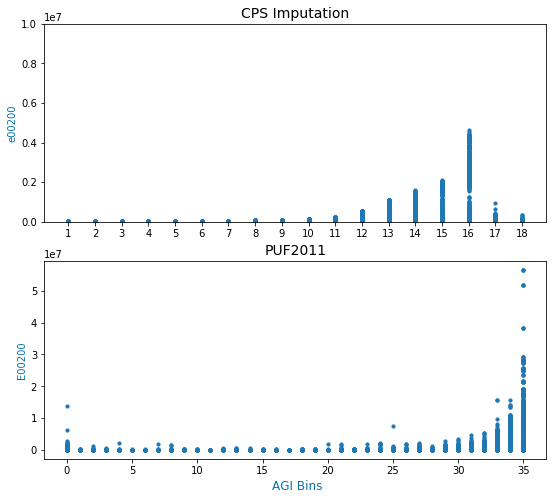

In [33]:
#E00200

plt.figure(num = 'e00200 dist', figsize = (9, 8))

plt.subplot(211)
plt.title('CPS Imputation', size = 14)
x0 = cps['agi_bin']
y0 = cps['e00200']
plt.xticks(range(19))
plt.ylabel('e00200', color = '#0872AE')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax = plt.gca()
ax.set_ylim([0, 1*10**7])
plt.scatter(x0, y0, s = 10)


plt.subplot(212)
x1 = puf2011['AGIR1']
y1 = puf2011['E00200']
plt.xlabel('AGI Bins',fontsize = 12, color = '#0872AE', position = (0.505,0))
plt.ylabel('E00200', color = '#0872AE')
plt.title('PUF2011', size = 14)
plt.scatter(x1, y1, label = 'PUF2011', s = 10)

plt.show()



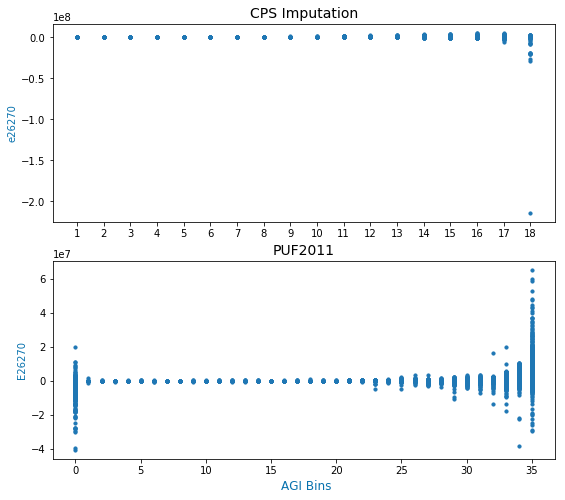

The CPS Imputation graph does not make sense to me because the predited e26270 is NOT mostly negative, in fact the mean is 117705.04048689055


In [34]:
#E26270

plt.figure(num = 'e26270 dist', figsize = (9, 8))

plt.subplot(211)
x0 = cps['agi_bin']
y0 = cps['e26270']
plt.ylabel('e26270', color = '#0872AE')
plt.xticks(range(19))
plt.title('CPS Imputation', size = 14)
plt.scatter(x0, y0, s = 10)

plt.subplot(212)
x1 = puf2011['AGIR1']
y1 = puf2011['E26270']
plt.xlabel('AGI Bins',fontsize = 12, color = '#0872AE', position = (0.505,0))
plt.ylabel('E26270', color = '#0872AE')
plt.title('PUF2011', size = 14)
plt.scatter(x1, y1, label = 'PUF2011', s = 10)

plt.show()

print('The CPS Imputation graph does not make sense to me because the predited e26270 is NOT mostly negative, in fact the mean is ' + str(cps['e26270'].mean()))

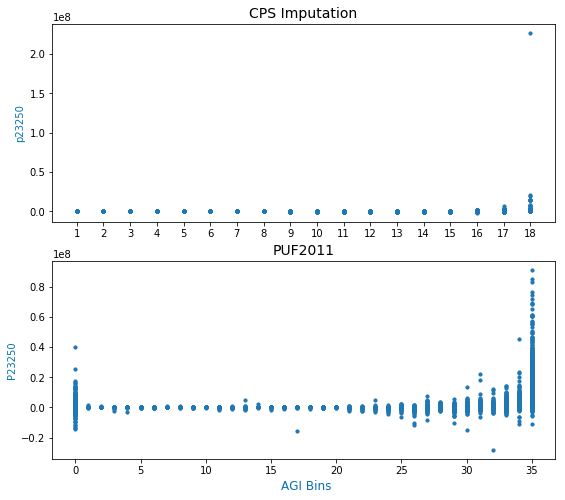

In [35]:
#P23250

plt.figure(num = 'p23250 dist', figsize = (9, 8))

plt.subplot(211)
x0 = cps['agi_bin']
y0 = cps['p23250']
plt.ylabel('p23250', color = '#0872AE')
plt.xticks(range(19))
plt.title('CPS Imputation', size = 14)
plt.scatter(x0, y0, s = 10)

plt.subplot(212)
x1 = puf2011['AGIR1']
y1 = puf2011['P23250']
plt.xlabel('AGI Bins',fontsize = 12, color = '#0872AE', position = (0.505,0))
plt.ylabel('P23250', color = '#0872AE')
plt.title('PUF2011', size = 14)
plt.scatter(x1, y1, label = 'PUF2011', s = 10)

plt.show()

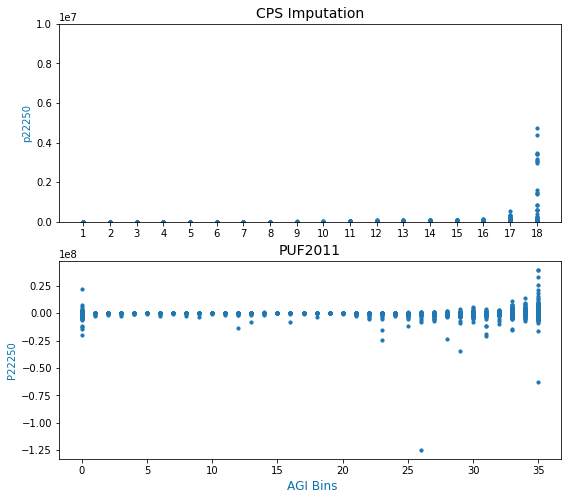

The predicted values are an order of magnitude lower than the observed


In [36]:
#P22250

plt.figure(num = 'p22250 dist', figsize = (9, 8))

plt.subplot(211)
plt.title('CPS Imputation', size = 14)
x0 = cps['agi_bin']
y0 = cps['p22250']
plt.xticks(range(19))
plt.ylabel('p22250', color = '#0872AE')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax = plt.gca()
ax.set_ylim([0, 1*10**7])
plt.scatter(x0, y0, s = 10)

plt.subplot(212)
x1 = puf2011['AGIR1']
y1 = puf2011['P22250']
plt.xlabel('AGI Bins',fontsize = 12, color = '#0872AE', position = (0.505,0))
plt.ylabel('P22250', color = '#0872AE')
plt.title('PUF2011', size = 14)
plt.scatter(x1, y1, label = 'PUF2011', s = 10)

plt.show()

print('The predicted values are an order of magnitude smaller than the observed')